In [1]:
import networkx as nx
import scipy.linalg as slg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.linalg as lg
from sklearn import preprocessing
from sklearn.manifold import MDS
import seaborn as sns
import scipy as sp
from pydiffmap import diffusion_map 
import random
sns.set_style('white')
from sklearn.preprocessing import Normalizer
random.seed(8579)
from scipy.spatial.distance import is_valid_dm
import ot
import copy
from scaccordion import tl as actl

2024-10-29 11:21:05.539140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


### dSBM comparison

Here we showcase our method and the considered baselines in the context of stochastic block models. *Note:* This examples is an adaptation of the structural comparison example provided by GOT (Maretic et. al..,2019).

In [2]:
n = 14;
g1 = nx.stochastic_block_model([7,7],[[0.9,0.1],[0.1,0.9]], seed = 8576,directed=True)
ug1 = nx.to_undirected(copy.deepcopy(g1))
g2 = copy.deepcopy(g1)
g2.remove_edge(2,13)
g2.remove_edge(8,0)
ug2 = nx.to_undirected(copy.deepcopy(g2))
g3 = copy.deepcopy(g1)
g3.remove_edge(1,3)
g3.remove_edge(10,9)
ug3 = nx.to_undirected(copy.deepcopy(g3))

In [3]:
cols1,cols2 = {},{}
thic1,thic2 = [],[]
for i in g1.edges():
    if i in [(2,13)] or i in [(8,0)]:#,(8,0)]:
        print(i,'red')
        cols1[i]='red'
        thic1.append(2.5)
    else:
        cols1[i]='gray'
        thic1.append(1.0)
for i in g1.edges():
    if i in [(1,3)] or i in [(10,9)]:#,(8,0)]:
        print(i,'red')
        cols2[i]='red'
        thic2.append(2.5)
    else:
        cols2[i]='gray'
        thic2.append(1.0)


(2, 13) red
(8, 0) red
(1, 3) red
(10, 9) red


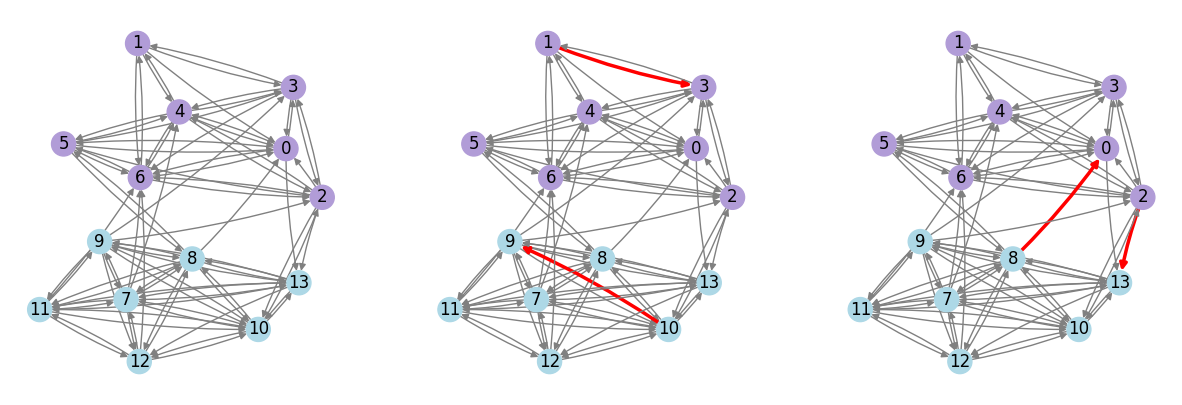

In [4]:
n = 14;
#g1 = nx.stochastic_block_model([7,7],[[0.a9,0.1],[0.1,0.9]], seed = 8576,directed=True)
g2 = copy.deepcopy(g1)
g2.remove_edge(2,13)
g2.remove_edge(8,0)
g3 = copy.deepcopy(g1)
g3.remove_edge(1,3)
g3.remove_edge(10,9)
aux1 = g2
g2 = g3
g3=aux1
_,ax2 = plt.subplots(1,3,figsize=(15,5),dpi=100)
ax2 = ax2.ravel()
ncol = []
for i in g1.nodes():
    if i <=6:
        ncol.append('#B19CD7')
    else:
        ncol.append('lightblue')
pos1 = nx.kamada_kawai_layout(g1)
nx.draw_networkx(g1,pos1,with_labels=True,ax=ax2[0],node_color=ncol,edge_color="gray",connectionstyle="arc3,rad=0.05")
ax2[0].axis('off')
#ax2[0].set_title('G')
nx.draw_networkx(g1,pos1,with_labels=True,ax=ax2[1],node_color=ncol,edge_color=list(cols2.values()),width=thic2,connectionstyle="arc3,rad=0.05")
ax2[1].axis('off')
#ax2[1].set_title('G3-Across Block')
nx.draw_networkx(g1,pos1,with_labels=True,ax=ax2[2],node_color=ncol,edge_color=list(cols1.values()),width=thic1,connectionstyle="arc3,rad=0.05")
ax2[2].axis('off')
#ax2[2].set_title('G2-Within Block')
plt.savefig('dSBM-structural-comparison.pdf')

In [5]:
cols = []
for i in ug1.edges():
    if i in [(2,13),(0,8)]:
        cols.append('darkorange')
    elif i in [(1,3),(9,10)]:
        cols.append('red')
    else:
        cols.append('gray')

In [6]:
lug1 = nx.laplacian_matrix(ug1)
lug2 = nx.laplacian_matrix(ug2)
lug3 = nx.laplacian_matrix(ug3)

#### Computing the Frobenius norm(Baseline 1) using the Directed Graphs Adjacency Matrix

In [7]:
l2c0 = np.linalg.norm(nx.to_numpy_array(g1) - nx.to_numpy_array(g1))
l2c1 = np.linalg.norm(nx.to_numpy_array(g1) - nx.to_numpy_array(g2))
l2c2 = np.linalg.norm(nx.to_numpy_array(g1) - nx.to_numpy_array(g3))
print('$Frobenius_norm(A_{1}-A_{2})$:'+f'{round(l2c1,3)}')
print('$Frobenius_norm(A_{1}-A_{3})$:'+f'{round(l2c2,3)}')

$Frobenius_norm(A_{1}-A_{2})$:1.414
$Frobenius_norm(A_{1}-A_{3})$:1.414


In [8]:
synthetic = {}
synthetic["G"] = nx.to_pandas_edgelist(g1)
synthetic["G"].columns = ['source','target']
synthetic["G"]['lr_means']=np.ones(len(synthetic['G'].index))
synthetic["G"]['source']=synthetic["G"]['source'].astype('str')
synthetic["G"]['target'] = synthetic["G"]['target'].astype('str')

synthetic["G1"] = nx.to_pandas_edgelist(g2)
synthetic["G1"].columns = ['source','target']
synthetic["G1"]['lr_means']=np.ones(len(synthetic['G1'].index))
synthetic["G1"]['source']=synthetic["G1"]['source'].astype('str')
synthetic["G1"]['target'] = synthetic["G1"]['target'].astype('str')

synthetic["G2"] = nx.to_pandas_edgelist(g3)
synthetic["G2"].columns = ['source','target']
synthetic["G2"]['lr_means']=np.ones(len(synthetic['G2'].index))
synthetic["G2"]['source']=synthetic["G2"]['source'].astype('str')
synthetic["G2"]['target'] = synthetic["G2"]['target'].astype('str')


In [9]:
Syn = actl.Accordion(tbls=synthetic,filter=0.0,weight='lr_means')
#Syn.make_pca()
#sns.scatterplot(x=0,y=1,data=Syn.Cs['PCA'])
#for i in range(Syn.Cs['PCA'].shape[0]):
#    plt.text(x=Syn.Cs['PCA'].iloc[i,0],
#             y=Syn.Cs['PCA'].iloc[i,1],
#             s=Syn.Cs['PCA'].index.tolist()[i])

#### Computing the directed Wasserstein costs

In [10]:
Syn.compute_cost(mode='GRD')
Syn.compute_cost(mode='HTD')
Syn.compute_cost(mode='HTD',beta=1)


#### Computing the directed Wasserstein Distances

In [11]:
Syn.compute_wassestein()
Syn.compute_wassestein(cost='HTD_0.5')
Syn.compute_wassestein(cost='HTD_1')

#### Computing the GWOT(Baseline 2,Chowdhury and Memoli, 2019) using the Directed Graphs Adjacency Matrix

In [12]:
fro1=[l2c0,l2c1,l2c2]
mg1 = nx.to_numpy_array(g1)
mg2 = nx.to_numpy_array(g2)
mg3 = nx.to_numpy_array(g3)
mA =(1/n)*np.ones(n)
gwot0 = actl.GWOT.emd2RTLB(mg1,mg1,mA,mA)
gwot = actl.GWOT.emd2RTLB(mg1,mg2,mA,mA)
gwot1 = actl.GWOT.emd2RTLB(mg1,mg3,mA,mA)

pre-EMD-time:0.0006682395935058594 minutes
post-EMD-time:1.1348724365234375e-05 minutes
pre-EMD-time:0.0006327072779337566 minutes
post-EMD-time:7.053216298421224e-06 minutes
pre-EMD-time:0.0006235480308532715 minutes
post-EMD-time:6.326039632161459e-06 minutes


In [31]:
gwot1

(0.0714285714392857,
 0.03571428570714285,
 0.0714285714392857,
 array([[0.        , 0.        , 0.07142857, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.07142857, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.07142857, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.07142857],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.07142857, 0.        , 0.        , 0.        , 0.        ,
         0.   

#### Computing the GOT(Baseline 3,Maretic, 2019) using the Directed Graphs Adjacency Matrix

In [13]:
ugot =[actl.wass_dist_(lug1.todense(),lug1.todense()), actl.wass_dist_(lug1.todense(),lug2.todense()),actl.wass_dist_(lug1.todense(),lug3.todense())]
lgwot=[gwot0[0],gwot[0],gwot1[0]]

In [14]:
distfrG = pd.DataFrame.from_dict({
                        '$Frobenius({A})$':fro1,
                        "$GOT_{undirected}$":ugot,
                        "$GWOT$":lgwot,
                        '$EMD-GRD$':Syn.wdist['GRD']['G'].tolist(),
                        '$EMD-HTD^{0.5}$':Syn.wdist['HTD_0.5']['G'].tolist(),
                        '$EMD-HTD^{1}$':Syn.wdist['HTD_1']['G'].tolist()})
distfrG.index=['G','G1','G2']
#sns.heatmap(distfrG.loc[['G','G2','G1'],:],cmap='OrRd',annot=True, fmt=".4f")1

In [15]:
g1m = nx.to_pandas_adjacency(g1).apply(lambda x:x/sum(x),axis=1).to_numpy()
g2m = nx.to_pandas_adjacency(g2).apply(lambda x:x/sum(x),axis=1).to_numpy()
g3m = nx.to_pandas_adjacency(g3).apply(lambda x:x/sum(x),axis=1).to_numpy()

#### Computing the Gromow-Wasserstein using the directed network distances

In [26]:
ctdg = actl.distances.getGRD(g1)
ctdg1 = actl.distances.getGRD(g2)
ctdg2 = actl.distances.getGRD(g3)

In [27]:
gwgrd=[ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg1,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg2,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss')]

In [28]:
ctdg = actl.distances.getCTD(g1m)
ctdg2 = actl.distances.getCTD(g2m)
ctdg3 = actl.distances.getCTD(g3m)

gwhtd05=[ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg2,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg3,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss')]
ctdg = actl.distances.getCTD(g1m,beta=1)
ctdg2 = actl.distances.getCTD(g2m,beta=1)
ctdg3 = actl.distances.getCTD(g3m,beta=1)

gwhtd1=[ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg2,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss'),
ot.gromov_wasserstein2(C1=ctdg,
                       C2=ctdg3,
                       p=ot.unif(n=ctdg.shape[0]),
                       q=ot.unif(n=ctdg.shape[0]),
                       loss_fun='square_loss')]

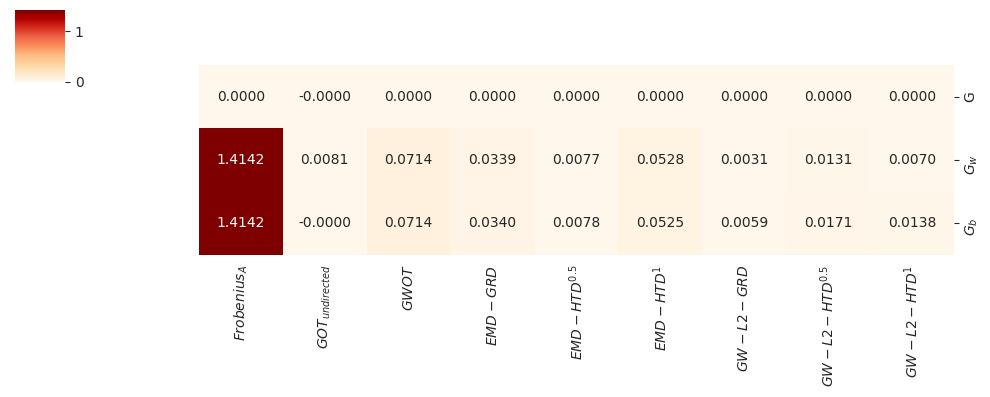

In [29]:
distfrG = pd.DataFrame.from_dict({
                        '$Frobenius_{A}$':fro1,
                        "$GOT_{undirected}$":ugot,
                        "$GWOT$":lgwot,
                        '$EMD-GRD$':Syn.wdist['GRD']['G'].tolist(),
                        '$EMD-HTD^{0.5}$':Syn.wdist['HTD_0.5']['G'].tolist(),
                        '$EMD-HTD^{1}$':Syn.wdist['HTD_1']['G'].tolist(),
                        '$GW-L2-GRD$':gwgrd,
                        '$GW-L2-HTD^{0.5}$':gwhtd05,
                        '$GW-L2-HTD^{1}$':gwhtd1,})
distfrG.index=['G','$G_w$','$G_b$']
sns.clustermap(distfrG.loc[['G','$G_w$','$G_b$'],:],
               cmap='OrRd',
               annot=True, 
               fmt=".4f",
               row_cluster=False,figsize=(10,4),method='single',col_cluster=False)